In [1]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import GridWorld_env
from replay_buffer import ReplayBuffer
import gymnasium as gym
import random
import math
from itertools import count

device = "cuda" if torch.cuda.is_available() else "cpu"
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
from collections import deque, namedtuple

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

In [2]:
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.99
EPS_END = 0.01
EPS_DECAY = 5500000
TAU = 0.0002
STEPSIZE = 0.00005
BETA_START = 0.4
BETA_END = 1
BETA_LINEAR_CAP = 5500 * 1500
N_STEP = 1

steps_done = 1000 * 3000
print(0.01 + (0.99 - 0.01) * math.exp(-1. * steps_done / EPS_DECAY))

0.5779867132091133


In [3]:
class DoubleDueling_DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        
        super(DoubleDueling_DQN, self).__init__()
        self.conv1 = nn.Conv3d(3, 29, 3, 1, 1)
        self.conv2 = nn.Conv3d(32, 67, 3, 1, 1)
        
        self.fc1 = nn.Linear((64 + 3*2)*input_dim * input_dim * input_dim, 1024)
        
        self.lstmcell = nn.LSTMCell(1024, 1024)
        
        self.actions = nn.Linear(2048, action_dim)
        self.advantage = nn.Linear(2048, 1)
    def forward(self, x, h, c):
        original_state = x
                    
        x = self.conv1(x)
        x = torch.cat([x, original_state], dim=1)
        x = F.gelu(x)
        
        x = self.conv2(x)
        x = torch.cat([x, original_state], dim=1)
        x = F.gelu(x)
        
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = F.gelu(x)
        
        h, c = self.lstmcell(x, (h, c))
        
        actions = self.actions(torch.cat([h, x], dim=1))
        advantage = self.advantage(torch.cat([h, x], dim=1))
        x = advantage + (actions - actions.mean(dim=1, keepdim=True))
        return x, h, c

In [4]:
n_actions = 10
env = gym.make("GridWorld_env/GridWorld", dimension_size=6, path="targets")
env.reset()

policy_net = DoubleDueling_DQN(6, n_actions).to(device)


c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: float64
  logger.warn(
c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [5]:
policy_net = torch.load("checkpoint1000_policy.pt")



In [6]:
def select_action(state, h, c, greedy=False):
    #global steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    #steps_done += 1
    
    if greedy:
        with torch.no_grad():
            out, h, c = policy_net(state, h, c)
            print(out)
            return out.max(1).indices.view(1,1), h, c
            #return policy_net(state, h, c).max(1).indices.view(1,1), h, c
        
    if sample > eps_threshold:
        with torch.no_grad():
            out, h, c = policy_net(state, h, c)
            print(out)
            
            return out.max(1).indices.view(1,1), h, c
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), h, c

    

tensor([[-8.8440, -8.8798, -8.8447, -8.8713, -8.8745, -8.8410, -9.6861, -9.6645,
         -9.6787, -9.6680]], device='cuda:0')
5


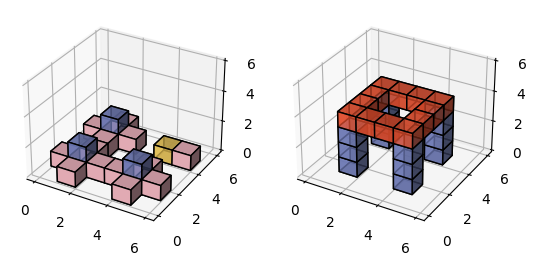

KeyboardInterrupt: 

In [10]:
import time
#state, info = env.reset()
state = env.get_obs()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
h = torch.zeros(1, 1024, dtype=torch.float32, device=device)
c = torch.zeros(1, 1024, dtype=torch.float32, device=device)

for t in count():
    
    action, h, c = select_action(state, h, c, True)
    observation, reward, terminated, truncated, _ = env.step((action.item(), 0))
    print(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    state = next_state
    if terminated or truncated:
        break
    env.unwrapped.render()                                                                                                                                                         
    time.sleep(0.5)
    display.clear_output(wait=True)

    
